In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class VAE(nn.Module):
    
    def __init__(self, obs_dim, latent_dim, hidden_dims=[100, 100]):
        """Initialize the VAE model.
        
        :args:
            obs_dim: Dimension of the observed data x, int
            latent_dim: Dimension of the latent variable z, int
            hidden_dim: Hidden dimension of the encoder/decoder networks, int
        """

        super().__init__()
        self.latent_dim = latent_dim
        
        self.linear0 = nn.Linear(obs_dim, hidden_dims[0])
        self.linear1 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.linear21 = nn.Linear(hidden_dims[1], latent_dim)
        self.linear22 = nn.Linear(hidden_dims[1], latent_dim)

        self.linear3 = nn.Linear(latent_dim, hidden_dims[0])
        self.linear31 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.linear4 = nn.Linear(hidden_dims[1], obs_dim)

    def encoder(self, x):
        """Obtain the parameters of q(z) for a batch of data points.
        
        :args:
            x: Batch of data points, shape [batch_size, obs_dim]
        
        :returns:
            mu: Means of q(z), shape [batch_size, latent_dim]
            logsigma: Log-sigmas of q(z), shape [batch_size, latent_dim]
        """

        h = torch.relu(self.linear1(torch.relu(self.linear0(x))))
        return self.linear21(h), self.linear22(h)

    def sample_with_reparam(self, mu, logsigma):
        """Draw sample from q(z) with reparametrization.
        
        We draw a single sample z_i for each data point x_i.
        
        :args:
            mu: Means of q(z) for the batch, shape [batch_size, latent_dim]
            logsigma: Log-sigmas of q(z) for the batch, shape [batch_size, latent_dim]
        
        :Returns:
            z: Latent variables samples from q(z), shape [batch_size, latent_dim]
        """

        sample = torch.empty_like(mu).normal_(0., 1.) * logsigma.exp() + mu
        return sample 

    def decoder(self, z):
        """Convert sampled latent variables z into observations x.
        
        :args:
            z: Sampled latent variables, shape [batch_size, latent_dim]
        
        :returns:
            theta: Parameters of the conditional likelihood, shape [batch_size, obs_dim]
        """
        
        decode = torch.sigmoid(self.linear4(torch.relu(self.linear31(torch.relu(self.linear3(z))))))
        return decode


    def kl_divergence(self, mu, logsigma):
        """Compute KL divergence KL(q_i(z)||p(z)) for each q_i in the batch.
        
        :args:
            mu: Means of the q_i distributions, shape [batch_size, latent_dim]
            logsigma: Logarithm of standard deviations of the q_i distributions,
                      shape [batch_size, latent_dim]
        
        :returns:
            kl: KL divergence for each of the q_i distributions, shape [batch_size]
        """
        
        kl_div = 0.5 * (mu.pow(2) + (2 * logsigma).exp() - 2 * logsigma - 1).sum(-1)
        return kl_div

    def elbo(self, x):
        """Estimate the ELBO for the mini-batch of data.
        
        :args:
            x: Mini-batch of the observations, shape [batch_size, obs_dim]
        
        :returns:
            elbo_mc: MC estimate of ELBO for each sample in the mini-batch, shape [batch_size]
        """

        mu, logsigma = self.encoder(x)
        z = self.sample_with_reparam(mu, logsigma)
        theta = self.decoder(z)
        log_obs_prob = -F.binary_cross_entropy(theta, x, reduction='none').sum(-1)
        kl = self.kl_divergence(mu, logsigma)
        elbo = log_obs_prob - kl
        return elbo

    def sample(self, num_samples):

        z = torch.empty(num_samples, self.latent_dim).normal_()
        theta = self.decoder(z)
        sample = torch.bernoulli(theta)
        return sample



In [4]:
def visualize_samples(samples, num_rows=4, num_cols=5):

    sns.set_style('white')
    num_total = num_rows * num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.5 * num_cols, 2 * num_rows))
    for i in range(num_total):
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(samples[i], cmap='gray', vmin=0.0, vmax=1.0)
        ax.set_title(f'Sample #{i+1}')
    plt.tight_layout()
    plt.show()


In [5]:
batch_size = 128
dataset = datasets.MNIST 

train_loader = torch.utils.data.DataLoader(
        dataset('data', train=True, download=True, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True,)

test_loader = torch.utils.data.DataLoader(
        dataset('data', train=False, download=True, transform=transforms.ToTensor()),
        batch_size=1000, shuffle=True,)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
obs_dim = 784
latent_dim = 32
hidden_dims = [256, 256]  

vae = VAE(obs_dim, latent_dim, hidden_dims)
opt = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [8]:
vae.train()
train_loss_avg = []
max_epochs = 200
epoch_count = []
display_step = 10
stopping_val = 0
epochprints = [1, 5, 25, 50, max_epochs-1]
for epoch in range(max_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    print(f'Epoch {epoch}')
    for ix, batch in enumerate(train_loader):
        x, y = batch
        x = x.view(x.shape[0], obs_dim)
        opt.zero_grad()
        loss = -vae.elbo(x).mean(-1)
        loss.backward()
        opt.step()
        num_batches += 1
        images, labels = iter(test_loader).next()
        images = images.view(images.shape[0], obs_dim)
        loss = -vae.elbo(images).mean(-1)
        train_loss_avg[-1] += loss.item()
        
    train_loss_avg[-1] /= num_batches
    epoch_count.append(epoch)
    if train_loss_avg[-1] > train_loss_avg[len(train_loss_avg)-2]:
          stopping_val += 1
    if epoch % display_step == 0:
            print('loss = ' + str(train_loss_avg[-1]))
    if epoch in epochprints:
        plot_latent_space(x)
        images, labels = iter(test_loader).next()
        # First visualise the original images
        print('Original images')
        show_image(torchvision.utils.make_grid(images[0:20],10,5))
        plt.show()
        # Reconstruct and visualise the imagesplo using the vae
        print('VAE reconstruction:')
        visualise_output(images[0:20], vae)
        print("VAE samples:")
        x_samples = vae.sample(20).view(-1, 28, 28).detach()
        visualize_samples(x_samples)
    if stopping_val > 20:
          break
        

Epoch 0
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


KeyboardInterrupt: ignored

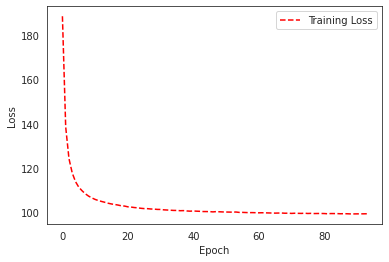

In [25]:
plt.plot(epoch_count, train_loss_avg, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

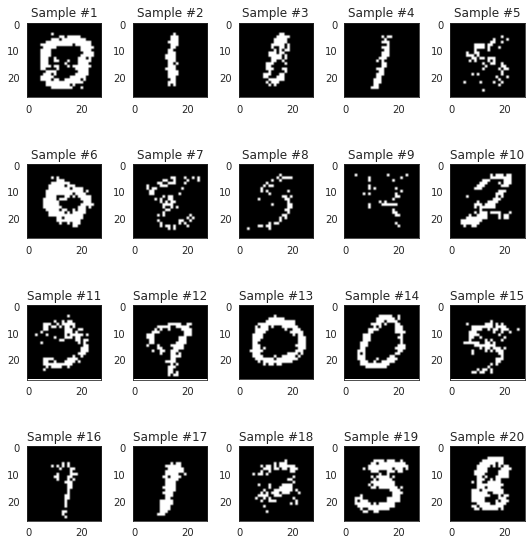

In [ ]:
images, labels = iter(test_loader).next()
# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:15],10,5))
plt.show()
# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)
print("VAE samples:")
x = vae.sample(20).view(-1, 28, 28).detach().numpy()
visualize_samples(x)

In [19]:
def plot_latent_space(x):
    latent = vae.encoder(x)[0]
    latent_embedded = TSNE(init='pca', n_components=2).fit_transform(latent.detach().numpy())
    N = 10
    plt.figure(figsize=(8, 6))
    plt.scatter(
        latent_embedded[:, 0],
        latent_embedded[:, 1],
        c=y,
       marker='o', edgecolor='none')
    plt.colorbar(ticks=range(N))
    plt.grid(True)
    plt.show()

In [21]:
# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def visualise_output(images, model):
    model.eval()
    with torch.no_grad():
        images = images.view(images.shape[0], obs_dim)
        latent_mu, latent_logvar = vae.encoder(images)
        latent = vae.sample_with_reparam(latent_mu, latent_logvar)
        theta = vae.decoder(latent)
        images = torch.bernoulli(theta).view(-1, 28, 28).detach()
        visualize_samples(images)
